In [34]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("src/")
import operator
from importlib import reload
import src.preprocessing.data_loading as data_loading
import models.experiment as experiment
import models.rnn as rnn
import analysis.umap_analysis as umap
import analysis.scatter_plots as scatter_plots
import analysis.evaluation as evaluation
from preprocessing.X_representation import RAA_to_seq
from preprocessing.X_representation_utils import initialize_Proc2Vec_embeddings
from utils.utils import find_3mer
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
import seaborn as sns
from sklearn.model_selection import train_test_split
import numpy as np
from matplotlib import pyplot as plt
from tensorflow import keras

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Train MDM2 vs. 12ca5 Model



In [133]:
import pdb
R3_lib = data_loading.read_data_and_preprocess(datafile="12ca5-MDM2-mCDH2-R3.csv")
protein_of_interest = "MDM2" 
other_protein = "12ca5"
X, mdm2_y, mdm2_y_raw, peptides, FEATURE_LIST = data_loading.build_dataset(
    R3_lib,
    protein_of_interest=protein_of_interest,
    other_protein=other_protein,
    aa_representations=[
        data_loading.AA_REPRESENTATION.PRO2VEC,
        data_loading.AA_REPRESENTATION.RAA,
        data_loading.AA_REPRESENTATION.PHYSIOCHEM_PROPERTIES,
        data_loading.AA_REPRESENTATION.ONE_HOT,
    ],
)

(
    X_train,
    X_test,
    mdm2_y_train,
    mdm2_y_test,
    mdm2_y_raw_train,
    mdm2_y_raw_test,
    peptides_train,
    peptides_test,
) = train_test_split(
    X,
    mdm2_y,
    mdm2_y_raw,
    peptides,
    test_size=0.2,
    shuffle=True,
    random_state=5,
)
mdm2_model = experiment.BinaryClassificationExperiment().train(
    X_train,
    mdm2_y_train,
    rnn.Joint_BinaryClassificationRNN_gelu,
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    # After initial training we are loading a pretrained model from memory
    load_trained_model=True,
    model_save_name='mdm2_bilstm_best.h5',
)
mdm2_y_pred_raw = mdm2_model(X_test)
mdm2_y_pred = mdm2_y_pred_raw > 0.5

all_targets = list(zip(X, peptides))


/Users/yitongtseo/Documents/GitHub/ml_phage_display/src/preprocessing/y_representation.py:66: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  lib["pvalues"] = sp.stats.ttest_ind(


 - log P value cutoff is -0.44638568713238386, and log FC value cutoff is -0.6565247891915524


## Train 12ca5 vs. MDM2 Model

In [59]:

# 12ca5 shares the same p-values just inverted log fold change
# so we can get away with using the same dataset and just
# inverting the y value
# TODO(Yitong): We want to put this away in some function
ca5_y_train = np.copy(mdm2_y_train)
ca5_y_train[:,1] = ca5_y_train[:,1] ==0

ca5_y_test= np.copy(mdm2_y_test)
ca5_y_test[:,1] = ca5_y_test[:,1] ==0

ca5_y_raw_train = np.copy(mdm2_y_raw_train)
ca5_y_raw_train[:,1] = -ca5_y_raw_train[:,1]

ca5_y_raw_test = np.copy(mdm2_y_raw_test)
ca5_y_raw_test[:,1] = -ca5_y_raw_test[:,1]

# ca5_model = experiment.BinaryClassificationExperiment().train(
#     X_train,
#     ca5_y_train,
#     rnn.Joint_BinaryClassificationRNN_gelu,
#     optimizer=keras.optimizers.Adam(learning_rate=0.001),
#     # After initial training we are loading a pretrained model from memory
#     load_trained_model=True,
#     model_save_name='12ca5_bilstm.h5',
# )
# ca5_y_pred_raw = ca5_model(X_test)
# ca5_y_pred = ca5_y_pred_raw > 0.5


In [60]:
# evaluate accuracy, precision, recall of trianed model
print('MDM2')
evaluation.classification_evaluation_joint(mdm2_y_test, mdm2_y_pred)

# print('\n12ca5')
# # evaluate accuracy, precision, recall of trianed model
# evaluation.classification_evaluation_joint(ca5_y_test, ca5_y_pred)

MDM2
P-VAL
	 accuracy:  0.7200364575421541
	 precision:  0.688961038961039
	 recall:  0.8868765672889384
	 # neg predictions:  1963
	 # pos predictions:  4620
Log Fold
	 accuracy:  0.8798420173173325
	 precision:  0.8765533028122956
	 recall:  0.9933296275708727
	 # neg predictions:  467
	 # pos predictions:  6116


In [61]:
# Can we even get away with just flipping the mdm2 model output?
ca5_y_pred_raw_derived_from_mdm2 = np.copy(mdm2_y_pred_raw)
ca5_y_pred_raw_derived_from_mdm2[:, 1] = 1-ca5_y_pred_raw_derived_from_mdm2[:,1]
ca5_y_pred_derived_from_mdm2 = ca5_y_pred_raw_derived_from_mdm2 > 0.5

print('\n12ca5 Derived from inverted MDM2 Model Output')
# evaluate accuracy, precision, recall of trianed model
evaluation.classification_evaluation_joint(ca5_y_test, ca5_y_pred_derived_from_mdm2)



12ca5 Derived from inverted MDM2 Model Output
P-VAL
	 accuracy:  0.7200364575421541
	 precision:  0.688961038961039
	 recall:  0.8868765672889384
	 # neg predictions:  1963
	 # pos predictions:  4620
Log Fold
	 accuracy:  0.8798420173173325
	 precision:  0.9229122055674518
	 recall:  0.3634064080944351
	 # neg predictions:  6116
	 # pos predictions:  467


Shows that Inverting the MDM2 model is essentially the same as training a separate 12ca5 model

## Hit Rate by BiLSTM Model Confidence Ranking 

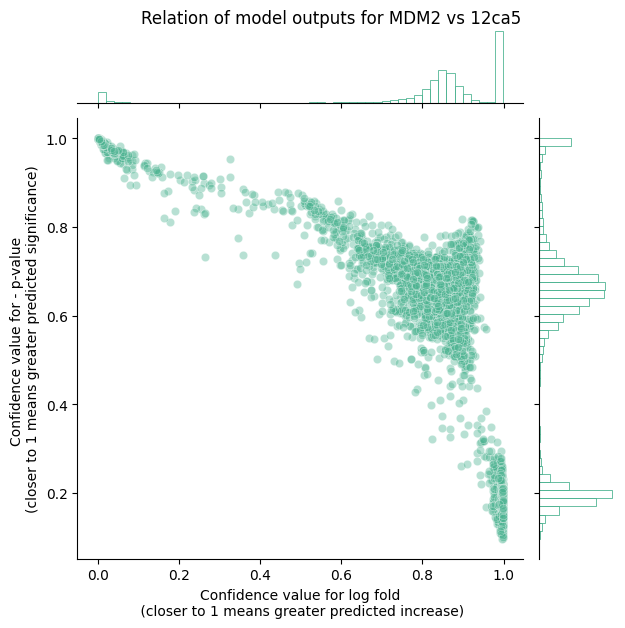

In [62]:
import matplotlib.pyplot as plt
import matplotlib


def show_volcano(y, protein_of_interest, other_protein, title, x_label, y_label):
    sns.set_palette(sns.color_palette("plasma"))
    p = sns.jointplot(
        x=y[:, 1],
        y=y[:, 0],
        color="#4CB391",
        alpha=0.4,
        marginal_kws=dict(bins=50, fill=False),
    )  
    p.fig.suptitle(title)
    p.set_axis_labels(x_label, y_label)
    p.fig.subplots_adjust(top=0.95) # Reduce plot to make room 



show_volcano(
    mdm2_model(X_test),
    protein_of_interest,
    other_protein,
    title=f"Relation of model outputs for {protein_of_interest} vs {other_protein}",
    x_label="Confidence value for log fold\n (closer to 1 means greater predicted increase)",
    y_label="Confidence value for - p-value \n(closer to 1 means greater predicted significance)",
)


normalized MDM2 area under curve:  0.5388586511128948
normalized 12ca5 area under curve:  0.9140910235961496


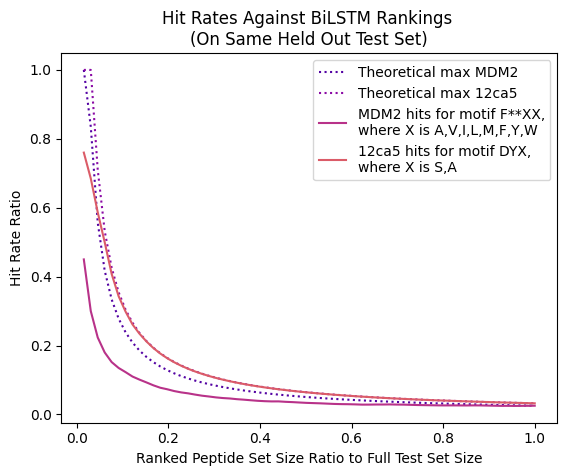

mdm2 hits!  ['AFWVWFWCS', 'AFFVWFWCS', 'AFFVWVWCS', 'AFSVWFWCS', 'AFCGWFWCS', 'AFCVWFWRS', 'AFCVWFLCS', 'AFFFWFWCS', 'AFCVWVWGS', 'AFCVWFWCP', 'AFSYWFWCS', 'AFCDWFWSS', 'AFCYLFWCS', 'ACFKSFVCG', 'AFCDLFWFS', 'ACVSFSCWW', 'AFCDWFCCS', 'ACFFSAFCR', 'AFSDWIWCS', 'ACKTFKCWW', 'ACKSFMCWW', 'AFCDWFWCG', 'ACTSFMWWW', 'AFFDWFWFS', 'AFCDWIWCS', 'ACKYFMCWW', 'AFCDWLWWS', 'AFCFWFECN', 'AFCDWVWCS', 'AFCYWFECN', 'AFCDWFWRS', 'ACRTFMCWW', 'ACSSFECWW', 'ACESFSCWW', 'AFCDWIWCC', 'ACEIFSCWW', 'ACITFMCWW', 'ACFHKYWRC', 'AFCPMWSCW', 'AFCDWFWCY', 'AFCDWFLCC', 'ACSTFEWFW', 'AFCDWVWCC', 'ACNTFLCWW', 'ACKAFMCWW', 'ACSPFECFW', 'AFWDWFWCA', 'AFCVWLLCS', 'ACQSFSCYW', 'AFCGFLCRL', 'AFCDLFWCV', 'AFCGFMCGS', 'AFCDWFGCN', 'AVCFSRLYC', 'AFCDWYLCS', 'AFCDWFVCN', 'ACERFACWW', 'AFCSFARCL', 'AYKTFMCWW', 'ACTTFMCWW', 'ACESFACWW', 'AFCDWFWYS', 'ACFQSIYCS', 'ACKTFMGWW', 'ACLFSDLFC', 'AFCDWFECK', 'AFCDWFECI', 'ACTTFECWW', 'ACFHKVMCR', 'AFCVWLWCA', 'ACFGTFMCN', 'ACKTFLCWL', 'AQCFSQIYC', 'AGCWFKCIA', 'ACHTFLCYW', 'ACKTFMCWL',

In [63]:
# Can we just literally reverse the prediction of the fc and get 12ca5 predictions?
ca5_y_pred_raw = np.copy(mdm2_y_pred_raw)
ca5_y_pred_raw[:, 1] = 1-ca5_y_pred_raw[:,1]

from analysis.hit_rate_analysis import plot_ratio_by_ranking

plot_ratio_by_ranking(peptides_test, mdm2_y_pred_raw, ca5_y_pred_raw, title='Hit Rates Against BiLSTM Rankings \n(On Same Held Out Test Set)')

## Hit Rate by Volcano Plot Ground Truth

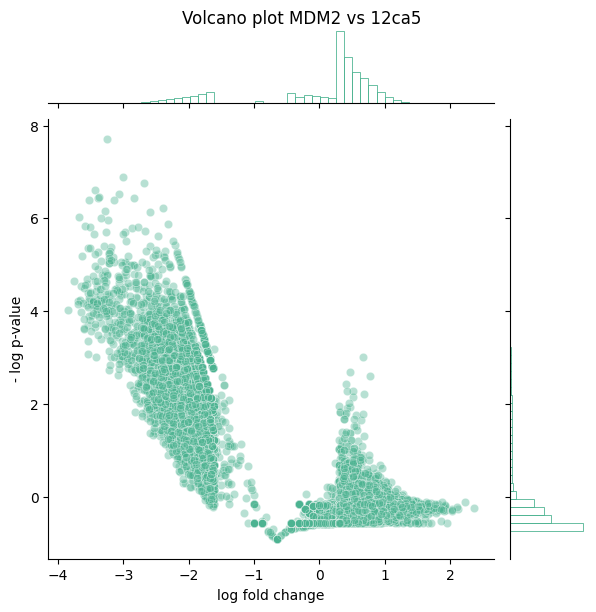

In [68]:
show_volcano(
    mdm2_y_raw,
    protein_of_interest,
    other_protein,
    title=f"Volcano plot {protein_of_interest} vs {other_protein}",
    x_label="log fold change",
    y_label="- log p-value",
)


normalized MDM2 area under curve:  0.2229014467927503
normalized 12ca5 area under curve:  0.6865970132913966


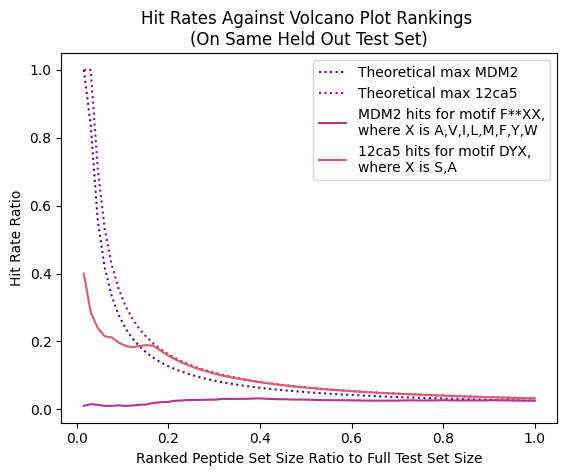

mdm2 hits!  ['ACYSFRCVM', 'ACNLFGCAV', 'HNFRTLV', 'QFRSFFH', 'EFLQLIS', 'APFNTIA', 'FPPLIWP', 'SYFPLWV', 'ACLFSDLFC', 'ACVGFGCWL', 'AFCDWFWCG', 'ACFGTFMCN', 'AFCDWFQCN', 'ACVHFGCLV', 'AFCDLFWCA', 'AFCVWFWRS', 'ACEIFSCWW', 'SDSLFWNMMTDV', 'ACGQFPCAA', 'SSFKHIV', 'AFWVWFWCS', 'ACKTFMGWW', 'AFCDWFGCN', 'AFCMFYCSE', 'FRPYATH', 'AFSDWIWCS', 'AFCDLFWFS', 'AFFDWFWFS', 'ACATFECFW', 'AGCWFKCIA', 'FPSWYSR', 'ACFQSIYCS', 'ACEIFKCVV', 'AFCGALCSH', 'KFVLLAR', 'ACNTFLCWW', 'STFSMWM', 'LPFNTFF', 'AFCHWFECN', 'AFFVWVWCS', 'ACFRHLACL', 'ACHTFLCYW', 'AFCFWFECN', 'AFCDWLWWS', 'AFCDWFEYN', 'FPFPKYM', 'AFSYWFWCS', 'AFCDWFECK', 'AFCDWIWCC', 'AFCDLFWCV', 'AFCVWVECI', 'ACITFMCWW', 'ACKTFLCWL', 'ACSTFEWFW', 'ACKTFKCWW', 'SFTFIAR', 'AFCDLFCCD', 'FTPLLPLRVYSA', 'AFCDWLWCP', 'AFCGAAVCR', 'AFCVWIECN', 'AFFFWFWCS', 'AFWDWFWCA', 'ACSPFECFW', 'AFCVWLLCS', 'AFSVWFWCS', 'ACSSFECWW', 'AFCVWFWCP', 'LFGSVYR', 'AHCGFQCLV', 'AFCVWLWCA', 'ACERFACWW', 'ACESFACWW', 'AFCDWYLCS', 'ACKYFMCWW', 'ACKAFMCWW', 'ACRTFMCWW', 'ACVSFSCWW

In [65]:
from analysis.hit_rate_analysis import plot_ratio_by_ranking

plot_ratio_by_ranking(
    peptides_test,
    mdm2_y_raw_test,
    ca5_y_raw_test,
    title="Hit Rates Against Volcano Plot Rankings \n(On Same Held Out Test Set)",
)
